In [43]:
import sqlite3
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

<h2> Skills </h2>
Come prima parte della generazione dei dati, è necessario specificare quali siano le possibili skill che un developer possa avere.


In [44]:
with sqlite3.connect('../datasets/skills_dataset.db') as skills_conn:
    skills_frame = pd.read_sql('SELECT * FROM Skills', skills_conn, index_col='ID') 
skills_frame

,SKILL,TYPE
ID,,
0,JavaScript,Programming Language
1,HTML,Programming Language
2,Python,Programming Language
3,SQL,Programming Language
4,TypeScript,Programming Language
...,...,...
100,Git,Tool
101,Travis,Tool
102,Swift,Programming Language


<h2> Generazione dei profili</h2>
<p> Si passa quindi ad usare un LLM per la generazione dei dati, in particolare GPT 3.5 Turbo</p>
<p> La generazione si svolge in questo modo</p>
<ul>
    <li> Generazione dei linguaggi di programmazione. </li>
    <li> Generazione dei framework. </li>
    <li> Generazione dei dei database conosciuti. </li>
    <li> Generazione dei tools conosciuti. </li>
    <li> Generazione delle piattaforme cloud. </li>
</ul>

<p> Sono state generate 508 tuple. </p>

In [45]:
gpt_generated_frame = pd.read_csv('../datasets/new_gpt_generated_dataset.csv', index_col='ID')

#gpt_generated_frame.drop_duplicates()

gpt_generated_frame


,Linguaggi di Programmazione,Framework,Database,Tools,Cloud
ID,,,,,
1,"HTML,CSS,JavaScript","React,Angular,Vue.js","MySQL,Oracle","npm,Webpack,Visual Studio",Heroku
2,"Python,JavaScript","Django,Flask,NumPy","MongoDB,MySQL","Pip,Homebrew,Composer",AWS
3,"TypeScript,JavaScript,CSS","React,Angular,Vue.js","PostgreSQL,MySQL","Yarn,Webpack,CMake",Google Cloud
4,"Bash,Python","NumPy,PyTorch,Scikit-Learn","MongoDB,Redis","Docker,Pacman,Homebrew",Docker
5,"Java,C++,HTML,CSS,JavaScript","Spring,JavaEE,React,Angular,Vue.js","MySQL,Oracle,Microsoft SQL Server","Maven,Gradle,Kubernetes",Azure
...,...,...,...,...,...
504,"CSS,JavaScript,HTML","React,Angular,Vue.js","MySQL,PostgreSQL","npm,Webpack,Visual Studio",Vercel
505,"HTML,CSS,JavaScript","React,Angular,Vue.js","MySQL,Redis","npm,Webpack,Visual Studio",Netlify
506,"Python,JavaScript,CSS","Django,Flask,NumPy","MongoDB,MySQL","Pip,Homebrew,Composer",AWS


<h2> Esplorazione dei dati Generati </h2>
<p> Si passa ora all'esplorazione dei dati generati. <br> </p>

C:\Users\Iacopo\AppData\Local\Temp\ipykernel_2232\3902896213.py:22: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=sorted_skills['count'], y=sorted_skills['SKILL'], palette="viridis")


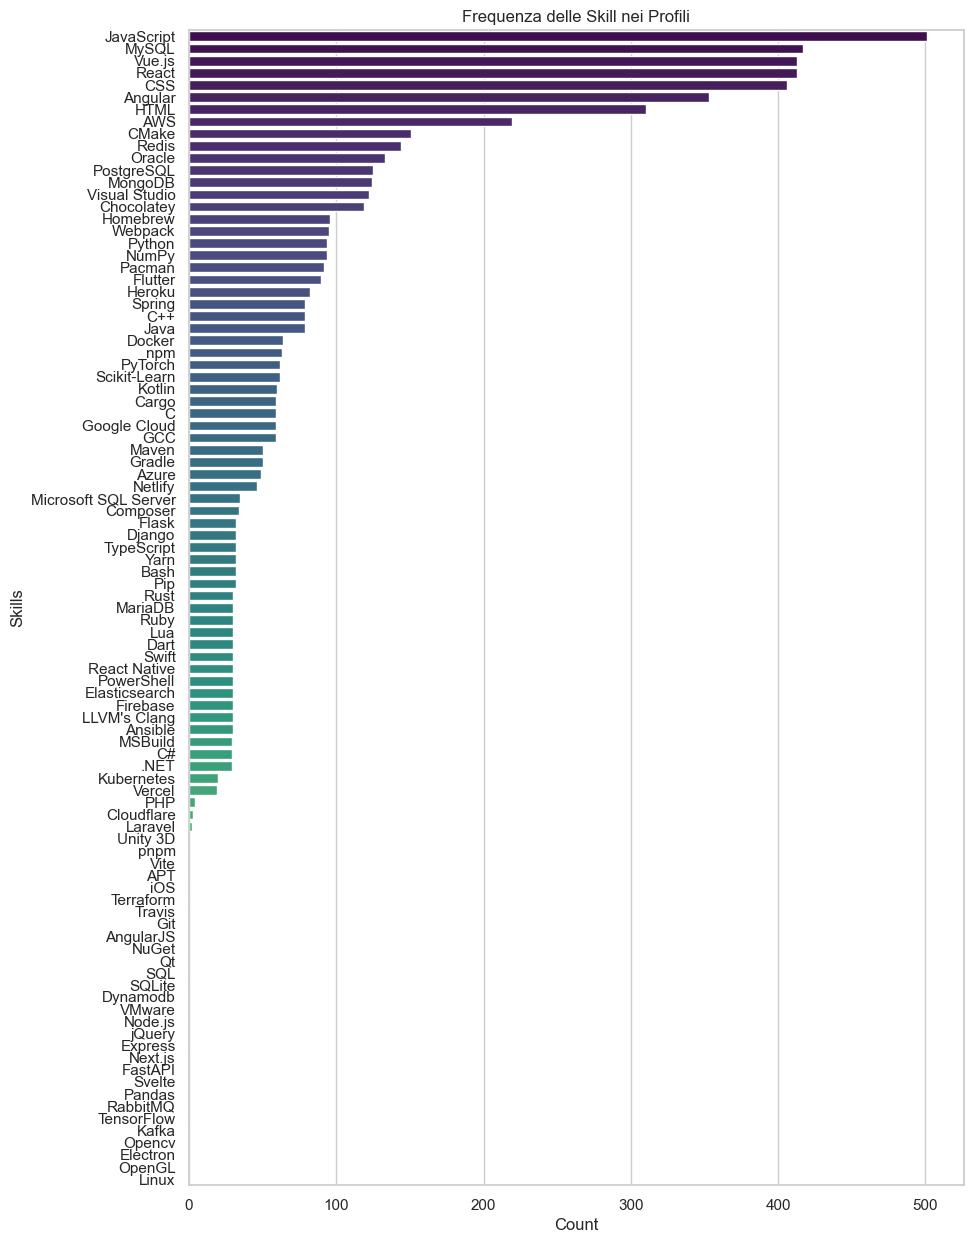

,progLang,framework,database,tools,cloud
count,509,509,509,509,509
unique,41,11,12,17,9
top,"TypeScript,JavaScript,CSS","React,Angular,Vue.js","MongoDB,MySQL","npm,Webpack,Visual Studio",AWS
freq,30,155,92,63,219


In [46]:
gpt_generated_frame.rename(columns={
    'Linguaggi di Programmazione': 'progLang',
    'Framework' : 'framework',
    'Database' : 'database',
    'Tools' : 'tools',
    'Cloud' : 'cloud'}, inplace= True)

skills_frame['count'] = 0

#for item in gpt_generated_frame.loc[:,'progLang']:
# Funzione per conteggio delle competenze
def count_skills(row, column_name):
    skills = row[column_name].split(',')
    skills_frame.loc[skills_frame['SKILL'].isin(skills), 'count'] += 1

for column in gpt_generated_frame.columns:
    gpt_generated_frame.apply(count_skills, args=(column,), axis=1)

sorted_skills = skills_frame.sort_values(by='count',ascending= False)

plt.figure(figsize=(10, 15))
sns.barplot(x=sorted_skills['count'], y=sorted_skills['SKILL'], palette="viridis")
plt.title("Frequenza delle Skill nei Profili")
plt.xlabel("Count")
plt.ylabel("Skills")
plt.show()

gpt_generated_frame.describe()

gpt_generated_frame.describe()

<h3> Considerazioni </h3>
<p> L'analisi per frequenza delle skill del dataset sintetico mostra alcune criticità </p>
<ul>
    <li> Anzitutto un elevato numero di skills risulta non utilizzato </li>
    <li> Alcune skills hanno monopolizzato la generazione, lasciando altre sottorappresentate, ad esempio: </li>
        <ol>
            <li>Vue.js ha monopolizzato la generazione dei framework.</li>
            <li>MongoDB è sovrarappresentato, rispetto a database popolari come Oracle.</li>
            <li>Tutti gli sviluppatori conoscono almeno una piattaforma cloud, non ncessariamente vero.</li>
            <li>Sono stati generati tool non presenti nel dataset delle competenze.</li>
        </ol>
  </li> 

In [47]:
gpt_generated_frame['count'] = 0


def count_skills(row):
    skills = str(row).split(',')
    return len(skills)
gpt_generated_frame['count'] = gpt_generated_frame.apply(count_skills, axis=1)

gpt_generated_frame

,progLang,framework,database,tools,cloud,count
ID,,,,,,
1,"HTML,CSS,JavaScript","React,Angular,Vue.js","MySQL,Oracle","npm,Webpack,Visual Studio",Heroku,9
2,"Python,JavaScript","Django,Flask,NumPy","MongoDB,MySQL","Pip,Homebrew,Composer",AWS,8
3,"TypeScript,JavaScript,CSS","React,Angular,Vue.js","PostgreSQL,MySQL","Yarn,Webpack,CMake",Google Cloud,9
4,"Bash,Python","NumPy,PyTorch,Scikit-Learn","MongoDB,Redis","Docker,Pacman,Homebrew",Docker,8
5,"Java,C++,HTML,CSS,JavaScript","Spring,JavaEE,React,Angular,Vue.js","MySQL,Oracle,Microsoft SQL Server","Maven,Gradle,Kubernetes",Azure,14
...,...,...,...,...,...,...
504,"CSS,JavaScript,HTML","React,Angular,Vue.js","MySQL,PostgreSQL","npm,Webpack,Visual Studio",Vercel,9
505,"HTML,CSS,JavaScript","React,Angular,Vue.js","MySQL,Redis","npm,Webpack,Visual Studio",Netlify,9
506,"Python,JavaScript,CSS","Django,Flask,NumPy","MongoDB,MySQL","Pip,Homebrew,Composer",AWS,9


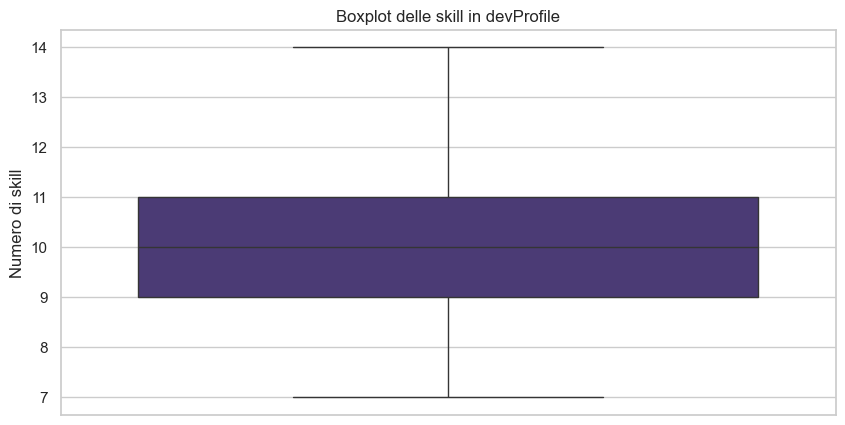

In [48]:
sns.set_palette("viridis")
plt.figure(figsize=(10,5)) 

sns.boxplot(y=gpt_generated_frame['count'])

# Add labels and title
plt.ylabel('Numero di skill')
plt.title('Boxplot delle skill in devProfile')

# Show the plot
plt.show()